In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'connect4/'

**Importing libraries**

In [0]:
#@title
import gym
!pip install kaggle_environments
from kaggle_environments import evaluate, make, utils
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from random import choice
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset 

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


# Utils

In [0]:
def preprocess(board, mark):
    return np.array([1 if val == mark else 0 if val == 0 else 2 for val in board])

def choose_action(state, q_net):
    board = torch.flatten(state, start_dim=0).numpy().reshape(6, 7)
    valid_actions = []
    for i in range(7):
        if np.count_nonzero(board[:, i]) != 6:
            valid_actions.append(i)
    prediction = q_net(state).argmax(dim=1).item()
    if prediction in valid_actions:
        return int(prediction)
    else:
        return int(np.random.choice(valid_actions))

 
def create_symetry(s):
    s = s.reshape(6, 7)
    s_ = torch.zeros(42).reshape(6, 7)
    for i in range(7):
        s_[:, i] = s[:, 6 - i]
    return s_.reshape(1, 6, 7)

def create_symetry_memory(state, action, next_state, reward):
    s_ = create_symetry(state)
    ns_ = create_symetry(next_state)
    a_ = 6 - action
    return s_, a_, ns_, reward

# **Q Network architecture**

In [0]:
class Network(nn.Module):
   
    def __init__(self, rows, columns, in_channels = 1):
        super().__init__()
        self.rows = rows
        self.columns = columns
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride = 1, padding = 1)
       # self.batch_norm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3, stride = 1, padding = 1)
       # self.batch_norm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(in_features=16 * 6 * 7, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=columns)
        
    def forward(self, t):
        # (2) hidden conv layer
        t = self.conv1(t)
     #   t = self.batch_norm1(t)
        t = F.relu(t)
       

        # (3) hidden conv layer
        t = self.conv2(t)
    #    t = self.batch_norm2(t)
        t = F.relu(t)
        
        # (4) hidden linear layer
        t = torch.flatten(t, start_dim=1)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) output layer
        t = self.out(t)
        
        return t

# **Replay memory**

In [0]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def add(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity
 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
 
    def can_sample(self, batch_size):
        return batch_size < len(self.memory)

    def dual_memory(self, m):
        arr = []
        for s, a, ns, r in m:
            arr.append(create_symetry_memory(s, a, ns, r))
        return arr

    def dataloader(self, batch_size, percent = 0.5):
        ms = int(len(self.memory) * percent)
        sample_memory = self.sample(ms)
        dataloader = DataLoader(sample_memory, batch_size, shuffle=True, drop_last=False)
        sample_memory = self.dual_memory(sample_memory)
        dataloader_dual = DataLoader(sample_memory, batch_size, shuffle=True, drop_last=False)
        return (dataloader, dataloader_dual)
 
    def __len__(self):
        return len(self.memory)
 

# **Epsilon greedy strategy**

In [0]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
 
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
               math.exp(-1. * current_step * self.decay)

# **Connect4 learner**

In [0]:
class Connect4Learner:
    def __init__(self,
                 rows,
                 columns,
                 memory,
                 learning_rate):
        self.policy_net = Network(rows, columns)
        self.target_net = Network(rows, columns)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.memory = memory
        self.actions = columns
        self.optimizer = optim.Adam(params=self.policy_net.parameters(), lr=learning_rate)
        self.loss = F.mse_loss
        self.strategy = EpsilonGreedyStrategy(EPS_START, EPS_END, EPS_DECAY)
        self.total_turns = 0
        self.avg_loss_per_fit = []
 
    def predict(self, state):
        return self.policy_net(state).argmax()

    def dqn_train(self, batch):
        state, action, next_state, reward = batch
        
        reward = reward.squeeze(1)
        action = action.long()

        q = self.policy_net(state).gather(dim=1, index=action).squeeze(1)
        q_, _= self.target_net(next_state).max(dim=1)

        sums = torch.sum(next_state.abs(), dim = [1, 2, 3])
        q_[sums == 0] = 0

        predicted = reward - q_ * GAMMA 
        curr_loss = self.loss(predicted, q)
        
        curr_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return curr_loss.item()
 
    def ddqn_train(self, batch):
        state, action, next_state, reward = batch
        
        reward = reward.squeeze(1)
        action = action.long()

        q = self.policy_net(state).gather(dim=1, index=action).squeeze(1)
         # argmaxQ(s', a')
        q_next = self.policy_net(next_state).argmax(dim=1).unsqueeze(1)
        # Q'(s', argmaxQ(s', a'))
        q_ = self.target_net(next_state).gather(dim=1, index=q_next).squeeze(1)
        sums = torch.sum(next_state.abs(), dim = [1, 2, 3])
        q_[sums == 0] = 0
        predicted = reward - q_ * GAMMA 

        curr_loss = self.loss(predicted, q)
        
        curr_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return curr_loss.item()


    def fit(self, epochs):
        if len(self.memory.memory) < MIN_MEMORY_SIZE:
            return

        dataloader, dataloader_dual = self.memory.dataloader(BATCH_SIZE)

        final_loss = 0.0
        for epoch in range(epochs):
            total_loss = 0
            batches = 0
            if epoch % 2 == 0:
                dl = dataloader
            else:
                dl = dataloader_dual
            for batch_ndx, sample in enumerate(dl):
                total_loss += self.ddqn_train(sample)
                batches += 1
            final_loss += total_loss
            print("Average loss per epoch", total_loss)
        final_loss /= epochs
        self.avg_loss_per_fit.append(final_loss)
    
    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
 
    def update_optimizer(self, learning_rate):
        self.optimizer = optim.Adam(params=self.policy_net.parameters(), lr=learning_rate)
 
    def get_action(self, state):
        self.total_turns += 1
        epsilon = self.strategy.get_exploration_rate(self.total_turns)
        board = torch.flatten(state, start_dim=0).numpy().reshape(6, 7)
        valid_actions = []
        for i in range(7):
            if np.count_nonzero(board[:, i]) != 6:
                valid_actions.append(i)

        if np.random.random() < epsilon:
            return int(np.random.choice(valid_actions))
        else:
            with torch.no_grad():
                prediction = self.policy_net(state).argmax(dim=1)
            return prediction.item()


# Connect4 Environment

In [0]:
class ConnectX(gym.Env):
    def __init__(self):
        self.env = make('connectx', debug=False)
 
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)
 
    def valid_action(self, action):
        return self.env.state[0].observation.board[action] == 0
    
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        return self.env.reset()
        
    def render(self, **kwargs):
        return self.env.render(**kwargs)
 
    def get_state(self):
        return self.env.state
 
    def get_preprocessed_state(self):
        board = self.env.state[0].observation.board
        mark = self.env.state[self.current_player()].observation.mark
        board_state = preprocess(board, mark)
        return torch.tensor(board_state, dtype=torch.float32).reshape(1, 6, 7)
 
    def game_over(self):
        return self.env.done
 
    def current_player(self):
        active = -1
        if self.env.state[0].status == "ACTIVE":
            active = 0
        if self.env.state[1].status == "ACTIVE":
            active = 1
        return active
 
    def get_configuration(self):
        return self.env.configuration

# **Hyperparameters**

In [0]:
BATCH_SIZE = 64
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 0.001
TARGET_UPDATE = 100
LEARNING_RATE = 0.0001
MIN_LEARNING_RATE = 0.000001
SAVE_MODEL = 1000
MEMORY_SIZE = 40000
MIN_MEMORY_SIZE = 30000
EPISODES = 800000
EPISODES += 5
TRAIN_STEP = 50
GAMMA = 0.999
EPOCHS = 4

model_base_path = "drive/My Drive/connect4/dqn/cnn_model"


# **Training**

In [0]:

env = ConnectX()
 
available_actions = env.action_space.n
 
replay_memory = ReplayMemory(MEMORY_SIZE)
 
input_features = env.observation_space.n

learner = Connect4Learner(input_features, available_actions, replay_memory, LEARNING_RATE)

episode = 1



In [0]:
def play_episode(learner, opponent = None, my_agent_id = None):
    env.reset()
    my_agent_won = True
    while not env.game_over():
        active = env.current_player()
        state = torch.tensor(env.get_preprocessed_state(), dtype=torch.float32)
        
        if my_agent_id is None or active == my_agent_id:
            action = learner.get_action(state.unsqueeze(0))
        else:
            action = choose_action(state.unsqueeze(0), opponent)
            
        env.step([action if i == active else None for i in [0, 1]])
        reward = env.get_state()[active].reward
        
        
        if env.game_over():
            if reward == 1:  # Won
                if my_agent_id != active:
                    my_agent_won = False
                elif reward == 0:  # Lost
                    if active == my_agent_id:
                        my_agent_won = False
                    reward = -1
                else:  
                    reward = 0
            else:
                reward = 0

        if reward != 0 and my_agent_id is not None:
            reward = 1 if my_agent_won else -1

        if not env.valid_action(action):
            reward = -1

        next_state = torch.tensor(env.get_preprocessed_state(), dtype=torch.float32)

        if env.game_over():
            next_state = torch.zeros(42).reshape(1, 6, 7)

        reward = torch.tensor([reward], dtype=torch.float32)
        action = torch.tensor([action], dtype=torch.float32)
        learner.memory.add(state, action, next_state, reward)

    return my_agent_won
                


In [0]:
#TODO: Fill learner memory.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Model saved


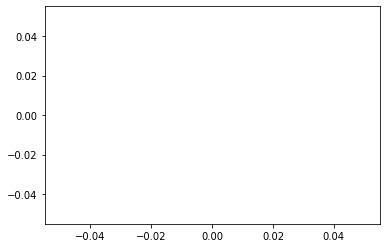

Average loss per epoch 10.28152689896524
Average loss per epoch 12.443138144910336
Average loss per epoch 9.264694774523377
Average loss per epoch 10.368436343967915
Average loss per epoch 10.177358098328114
Average loss per epoch 10.488942513708025
Average loss per epoch 9.382193909492344
Average loss per epoch 9.73408970143646
Average loss per epoch 8.93609678465873
Average loss per epoch 9.615873645991087
Average loss per epoch 8.206215647049248
Average loss per epoch 8.582351923920214
Average loss per epoch 8.80399451777339
Average loss per epoch 9.150805461220443
Average loss per epoch 8.262008474208415
Average loss per epoch 8.568526721559465
Average loss per epoch 10.045157296117395
Average loss per epoch 9.08252821676433
Average loss per epoch 9.138638137839735
Average loss per epoch 8.432744049001485
Average loss per epoch 9.404657465405762
Average loss per epoch 9.047667583916336
Average loss per epoch 8.89202253264375
Average loss per epoch 8.592789771500975
Average loss per

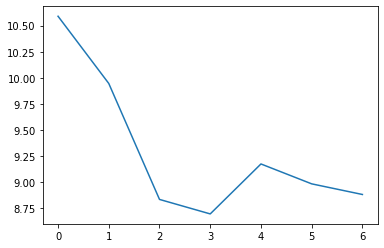

Average loss per epoch 9.233539268840104
Average loss per epoch 9.459664921276271
Average loss per epoch 8.794238992966712
Average loss per epoch 9.050429916474968
Average loss per epoch 10.829101742245257
Average loss per epoch 11.477584959473461
Average loss per epoch 10.006456759758294
Average loss per epoch 10.318708643317223
Average loss per epoch 10.23338195681572
Average loss per epoch 10.810302618891
Average loss per epoch 9.755511600524187
Average loss per epoch 10.273884951137006
Average loss per epoch 10.41384065989405
Average loss per epoch 10.209881589747965
Average loss per epoch 9.628821710590273
Average loss per epoch 9.482827282045037
Average loss per epoch 9.097541509196162
Average loss per epoch 9.681471184827387
Average loss per epoch 8.708585661370307
Average loss per epoch 9.260319539811462
Average loss per epoch 9.95508865499869
Average loss per epoch 10.31130153965205
Average loss per epoch 9.295716013293713
Average loss per epoch 9.75223063165322
Average loss p

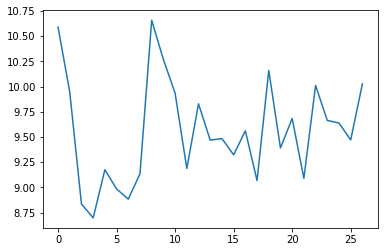

Average loss per epoch 10.158357956912369
Average loss per epoch 10.39948357688263
Average loss per epoch 9.83794241771102
Average loss per epoch 10.086568844504654
Average loss per epoch 10.536678606178612
Average loss per epoch 10.096516247838736
Average loss per epoch 10.107507421635091
Average loss per epoch 9.638820328749716
Average loss per epoch 10.950071915052831
Average loss per epoch 11.02290994534269
Average loss per epoch 10.5794354849495
Average loss per epoch 10.652964643202722
Average loss per epoch 11.493123347871006
Average loss per epoch 11.173772501759231
Average loss per epoch 10.931894806912169
Average loss per epoch 10.751108426600695
Average loss per epoch 11.203880447894335
Average loss per epoch 11.13242272194475
Average loss per epoch 10.795709056314081
Average loss per epoch 10.776187885552645
Average loss per epoch 11.200095056556165
Average loss per epoch 11.207824678625911
Average loss per epoch 10.759734475053847
Average loss per epoch 10.78982089459896
A

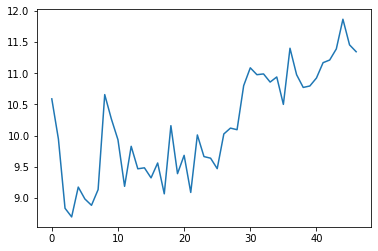

Average loss per epoch 12.52408866584301
Average loss per epoch 12.607508984394372
Average loss per epoch 12.092544152401388
Average loss per epoch 12.167017036117613
Average loss per epoch 11.995174596086144
Average loss per epoch 12.505362499505281
Average loss per epoch 11.517460169270635
Average loss per epoch 12.096073996275663
Average loss per epoch 11.578269049525261
Average loss per epoch 11.656282181851566
Average loss per epoch 11.237203762866557
Average loss per epoch 11.320850596763194
Average loss per epoch 12.060917221941054
Average loss per epoch 11.921498876065016
Average loss per epoch 11.645295600406826
Average loss per epoch 11.588771378621459
Average loss per epoch 11.464795577339828
Average loss per epoch 12.066191151738167
Average loss per epoch 11.024659112095833
Average loss per epoch 11.549619745463133
Average loss per epoch 11.832989127375185
Average loss per epoch 12.23660258948803
Average loss per epoch 11.291908250190318
Average loss per epoch 11.7195804715

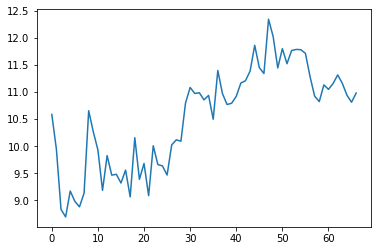

Average loss per epoch 11.282192265614867
Average loss per epoch 11.059804913587868
Average loss per epoch 10.909987955354154
Average loss per epoch 10.769812727347016
Average loss per epoch 11.141046326607466
Average loss per epoch 11.22919401852414
Average loss per epoch 10.596959598362446
Average loss per epoch 10.848714778199792
Average loss per epoch 10.977965019643307
Average loss per epoch 11.7090457752347
Average loss per epoch 10.624945127405226
Average loss per epoch 11.33546620933339
Average loss per epoch 11.781480211764574
Average loss per epoch 12.146044964436442
Average loss per epoch 11.210703583434224
Average loss per epoch 11.649659125134349
Average loss per epoch 12.101660158485174
Average loss per epoch 12.273487254511565
Average loss per epoch 11.64389350079
Average loss per epoch 11.932076799683273
Average loss per epoch 12.85652700997889
Average loss per epoch 12.416082597337663
Average loss per epoch 12.318695997819304
Average loss per epoch 11.914822490420192
A

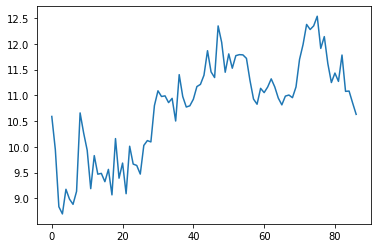

Average loss per epoch 10.170795248355716
Average loss per epoch 10.499170037452132
Average loss per epoch 9.866219417192042
Average loss per epoch 10.236855138093233
Average loss per epoch 10.572395201772451
Average loss per epoch 10.790238962508738
Average loss per epoch 10.190902644768357
Average loss per epoch 10.418355449102819
Average loss per epoch 10.573526163585484
Average loss per epoch 12.02125582844019
Average loss per epoch 10.251723242923617
Average loss per epoch 11.532959900796413
Average loss per epoch 10.57749777380377
Average loss per epoch 11.69990102108568
Average loss per epoch 10.258195013739169
Average loss per epoch 11.247850868850946
Average loss per epoch 10.870200077071786
Average loss per epoch 11.646110548637807
Average loss per epoch 10.621624481864274
Average loss per epoch 11.278863275889307
Average loss per epoch 11.349464399274439
Average loss per epoch 11.757448115386069
Average loss per epoch 10.865754512138665
Average loss per epoch 11.298189906403

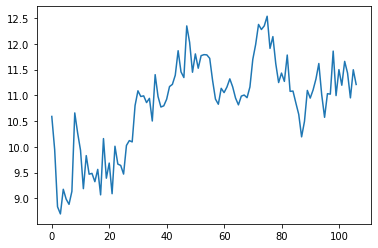

Average loss per epoch 10.71556420205161
Average loss per epoch 11.839905800763518
Average loss per epoch 10.402925586793572
Average loss per epoch 11.51861549820751
Average loss per epoch 11.76512361690402
Average loss per epoch 12.749239490367472
Average loss per epoch 11.282589242327958
Average loss per epoch 12.275410592090338
Average loss per epoch 11.506206359248608
Average loss per epoch 12.849239805713296
Average loss per epoch 11.093293820507824
Average loss per epoch 12.452487852424383
Average loss per epoch 11.395722629036754
Average loss per epoch 12.857477728277445
Average loss per epoch 10.988564825616777
Average loss per epoch 12.385454611852765
Average loss per epoch 11.635275004897267
Average loss per epoch 13.228173555340618
Average loss per epoch 11.230882623232901
Average loss per epoch 12.845642917789519
Average loss per epoch 10.830331856384873
Average loss per epoch 12.580029342323542
Average loss per epoch 10.441283090040088
Average loss per epoch 12.10135508561

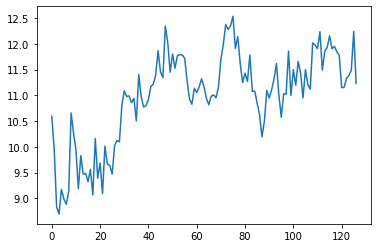

Average loss per epoch 10.586487772874534
Average loss per epoch 11.949110336601734
Average loss per epoch 10.190787049476057
Average loss per epoch 11.560983754694462
Average loss per epoch 10.808871529530734
Average loss per epoch 11.776378461159766
Average loss per epoch 10.507174863480031
Average loss per epoch 11.352549066767097
Average loss per epoch 10.77865289337933
Average loss per epoch 11.717245968058705
Average loss per epoch 10.421173945534974
Average loss per epoch 11.284231331199408
Average loss per epoch 11.220437472686172
Average loss per epoch 11.376567504368722
Average loss per epoch 10.7329161465168
Average loss per epoch 10.916338847018778
Average loss per epoch 10.880722576286644
Average loss per epoch 11.214090197347105
Average loss per epoch 10.551720190793276
Average loss per epoch 10.9036082373932
Average loss per epoch 11.243741311132908
Average loss per epoch 11.52480308804661
Average loss per epoch 10.80734119284898
Average loss per epoch 11.10166348097846


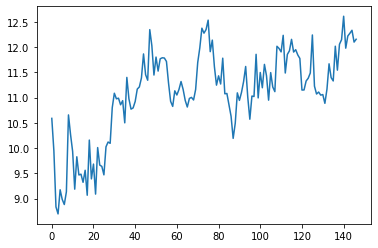

Average loss per epoch 12.701203182339668
Average loss per epoch 12.538400321267545
Average loss per epoch 12.281407966278493
Average loss per epoch 12.11913376674056
Average loss per epoch 11.825579162687063
Average loss per epoch 12.04852186422795
Average loss per epoch 11.487545060925186
Average loss per epoch 11.621562306303531
Average loss per epoch 12.28340928722173
Average loss per epoch 12.217152064666152
Average loss per epoch 11.97770329657942
Average loss per epoch 11.738051599822938
Average loss per epoch 13.400430236943066
Average loss per epoch 12.27431788109243
Average loss per epoch 12.832125685177743
Average loss per epoch 11.804100436158478


In [0]:
episode = 62001
learner.policy_net.load_state_dict(torch.load(model_base_path + str(62000)))
learner.policy_net.train()
learner.update_target_net()
learner.total_turns = max(learner.total_turns, 1e6)

while episode < EPISODES:
    episode += 1
    env.reset()
    play_episode(learner)

    if episode % SAVE_MODEL == 0:
        path = model_base_path + str(episode)
        print("Model saved")
        torch.save(learner.policy_net.state_dict(), path)
        plt.clf()
        plt.plot(learner.avg_loss_per_fit)
        plt.show()

    if len(learner.memory.memory) < MIN_MEMORY_SIZE:
        continue
    
    if episode % TRAIN_STEP == 0:
        learner.fit(EPOCHS)
 
    if episode % TARGET_UPDATE == 0:
        learner.update_target_net()
        

In [0]:
plt.plot(learner.avg_loss_per_fit)
plt.show()

In [0]:
start_model_id = 3000
end_model_id = 9000
curr_model_id = 10000
my_model_active = 0
learner = Connect4Learner(input_features, available_actions, replay_memory, LEARNING_RATE)
learner.policy_net.load_state_dict(torch.load(model_base_path + str(end_model_id)))
learner.policy_net.train()
learner.update_target_net()
consecutive_losses = 0
curr_learning_rate = LEARNING_RATE
learner.total_turns = max(learner.total_turns, 1e6)
model_step = 1000
while True:
    curr_model_wins = 0
    past_model_wins = 0
    for episode in range(model_step):
        env.reset()
        my_model_active =(my_model_active + 1) % 2
        total_models = int((end_model_id - start_model_id) / model_step)
        from random import randint
        active_model = randint(0, total_models)
        active_model = active_model * model_step + start_model_id
        past_dqn = Network(6, 7)
        past_dqn.load_state_dict(torch.load(model_base_path + str(active_model)))
        past_dqn.eval()
        my_agent_won = play_episode(learner, past_dqn, my_model_active)

        if my_agent_won:
            curr_model_wins += 1
        else:
            past_model_wins += 1
                
        
        if episode % TRAIN_STEP == 0:
            learner.fit(EPOCHS)
 
        if episode % TARGET_UPDATE == 0:
            learner.update_target_net()
 

   
    win_percentage_curr = (curr_model_wins / model_step) * 100
    win_percentage_past = (past_model_wins / model_step) * 100
    print("Current model winrate", win_percentage_curr)
    print("Past model winrate", win_percentage_past)
    plt.clf()
    plt.plot(learner.avg_loss_per_fit)
    plt.show()
   
    if len(learner.memory.memory) > 5000:
        consecutive_losses += 1

    if win_percentage_curr > 55.0:
        consecutive_losses = 0
        path = model_base_path + str(curr_model_id)
        start_model_id += model_step
        end_model_id += model_step
        curr_model_id += model_step
        print("Model saved")
        torch.save(learner.policy_net.state_dict(), path)
        

    if consecutive_losses > 10:
        curr_learning_rate /= 10
        next_learning_rate = max(curr_learning_rate, MIN_LEARNING_RATE)
        consecutive_losses = 0
        print("Next learning rate ", next_learning_rate)
        learner.update_optimizer(next_learning_rate)

# **Evaluation**

In [0]:
wawa = Network(6, 7)
wawa.load_state_dict(torch.load(model_base_path + '403000'))
wawa.eval()

def my_agent(observation, configuration):
    state = observation
    state = np.array([1 if val == state.mark else 0 if val == 0 else 2 for val in state.board])
    state = torch.tensor(state, dtype=torch.float32).reshape(1, 1, 6, 7)
    # print(state.numpy().reshape(6, 7))
    # print(wawa(state))
    action = choose_action(state, wawa)
    # print(action)
    return action


# env = make("connectx", debug=True)
# env.run(["random", my_agent])
# env.render()

def mean_reward(rewards):
    return sum(r[0] if r[0] == 1 else 0 for r in rewards) / len(rewards)

print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

# Creating the agent

In [0]:
#@title
def agent_function(observation, configuration):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import numpy as np
    import random
    import math
    import base64
    import io
    import time

    N = 7
    M = 6
    WIN = 10000
    LOSS = -10000

    def validMove(board, move):
        return board[move] == 0

    def makeMove(board, move, player):
        newBoard = list(board)
        # drop it
        if validMove(newBoard, move) is False:
            return -1

        last = 0
        for i in range(move, N * M, N):
            if newBoard[i] == 0:
                last = i
                continue
            break

        newBoard[last] = player
        return newBoard


    def points(board, player):
        result = 0

        for i in range(len(board)):
            n = i % N
            m = math.floor(i / N)

            if board[i] == player:
                # horizontal
                k = 0
                for j in range(i + 1, (m + 1) * N):
                    k = k + 1
                    if board[j] == player:
                        result = result + k
                        if k == 3:
                            return WIN
                    else:
                        break

                # vertical
                k = 0
                for j in range(i + N, M * N, N):
                    k = k + 1
                    if board[j] == player:
                        result = result + k
                        if k == 3:
                            return WIN
                    else:
                        break

                # diagonal right
                k = 0
                for j in range(1, N - n):
                    k = k + 1
                    next = i + ((N + 1) * j)
                    if next < (N * M) and board[next] == player:
                        result = result + k
                        if k == 3:
                            return WIN
                    else:
                        break

                # diagonal left
                k = 0
                for j in range(1, n + 1):
                    k = k + 1
                    next = i + ((N - 1) * j)
                    if next < (N * M) and board[next] == player:
                        result = result + k
                        if k == 3:
                            return WIN
                    else:
                        break

        return result


    def will_lose(board, action, player_id):
        next_board = makeMove(board, action, player_id)
        other_player = 1 if player_id == 2 else 2
        if next_board != -1 and points(next_board, player_id) == WIN:
            return False

        if next_board == -1:
            return False

        for j in range(7):
            next_board_other = makeMove(next_board, j, other_player)
            if next_board_other == -1:
                continue
            if points(next_board_other, other_player) == WIN:
                return True
        return False


    def can_win(board, player_id):
        for i in range(7):
            next_board = makeMove(board, i, player_id)
            if next_board != -1 and points(next_board, player_id) == WIN:
                return i
        return -1

   
    class Network(nn.Module):
   
        def __init__(self, rows, columns, in_channels = 1):
            super().__init__()
            self.rows = rows
            self.columns = columns
            self.in_channels = in_channels
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride = 1, padding = 1)
            # self.batch_norm1 = nn.BatchNorm2d(8)
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3, stride = 1, padding = 1)
            # self.batch_norm2 = nn.BatchNorm2d(16)
            self.fc1 = nn.Linear(in_features=16 * 6 * 7, out_features=128)
            self.out = nn.Linear(in_features=128, out_features=columns)
            
        def forward(self, t):
            # (2) hidden conv layer
            t = self.conv1(t)
            #t = self.batch_norm1(t)
            t = F.relu(t)
        

            # (3) hidden conv layer
            t = self.conv2(t)
            #t = self.batch_norm2(t)
            t = F.relu(t)
            
            # (4) hidden linear layer
            t = torch.flatten(t, start_dim=1)
            t = self.fc1(t)
            t = F.relu(t)

            # (5) output layer
            t = self.out(t)
            
            return t

    device = torch.device('cpu')
    policy_net = Network(6, 7)
    encoded_weights = """
    BASE64_PARAMS"""
    decoded = base64.b64decode(encoded_weights)
    buffer = io.BytesIO(decoded)
    policy_net.load_state_dict(torch.load(buffer, map_location=device))
    policy_net.eval()

    def preprocess(board, mark):
        return np.array([1 if val == mark else 0 if val == 0 else 2 for val in board])

    def get_preprocessed_state():
        board = observation.board
        mark = observation.mark
        board_state = preprocess(board, mark)
        return torch.tensor(board_state, dtype=torch.float32).reshape(1, 1, 6, 7)
    state = get_preprocessed_state()

    board = np.array(observation.board).reshape(6, 7)
    valid_actions = []

    with torch.no_grad():
        prediction = policy_net(state).argmax(dim=1).item()

    win_action = can_win(observation.board, observation.mark)



    desired_actions = []

    for i in range(7):
        if np.count_nonzero(board[:, i]) != 6:
            valid_actions.append(i)

        if np.count_nonzero(board[:, i]) != 6 and not will_lose(observation.board, i, observation.mark):
            desired_actions.append(i)
    # print(observation.mark)
    # print(board)
    # print(win_action)
    # print(desired_actions)
    # print()

    if win_action != -1:
        return win_action

    if prediction in desired_actions:
        return int(prediction)
    else:
        if len(desired_actions) > 0:
            return desired_actions[0]
        return int(np.random.choice(valid_actions))

In [0]:
import inspect
import os

no_params_path = "submission_template.py"
def append_object_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)
        
def write_agent_to_file(function, file):
    with open(file, "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(agent_function, no_params_path)

# Write net parameters to submission file

import base64
import sys
model_id = 403000
INPUT_PATH = "drive/My Drive/connect4/ddqn/cnn_model" + str(model_id) # model name
OUTPUT_PATH = 'drive/My Drive/connect4/submission' + str(model_id) + '.py'

with open(INPUT_PATH, 'rb') as f:
    raw_bytes = f.read()
    encoded_weights = base64.encodebytes(raw_bytes).decode()

with open(no_params_path, 'r') as file:
    data = file.read()

data = data.replace('BASE64_PARAMS', encoded_weights)

with open(OUTPUT_PATH, 'w') as f:
    f.write(data)
    print('written agent with net parameters to', OUTPUT_PATH)

In [0]:
import sys
out = sys.stdout
try:
    submission = utils.read_file(OUTPUT_PATH)
    agent = utils.get_last_callable(submission)
finally:
    sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")